In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import shutil
from scipy import signal

%matplotlib inline

## Data Analysis

---

Loading the data and analysing it

In [2]:
# Changing working directory
os.chdir(r'G:\Masters\Thesis\Data\data')

# Get all files in the directory
current_path = os.getcwd()
file_names = os.listdir(current_path)

# Get .csv files
csv_files = []
for file in file_names:

    if '.csv' in file:
        csv_files.append(file)

In [3]:
# Reading files
dfs =[]
for file in csv_files:

    df = pd.read_csv(file)
    dfs.append(df)

# Combine all dataframes
test_df = pd.concat(dfs, axis=0, ignore_index=True)

print(f'There are total number of {test_df.shape[0]} rows')
test_df.head()

There are total number of 24 rows


,Unnamed: 0,date,time,kks,data,unit,duration,dt
0,0,07/19/2023,14:30:00,32_COMP_RAW_PRO_XREL,"[-8.713050842285156, -8.711616516113281, -8.71...",um,1,0.00004
1,1,07/21/2023,14:30:00,32_COMP_RAW_PRO_XREL,"[-8.726463317871094, -8.725486755371094, -8.72...",um,1,0.00004
2,2,07/22/2023,14:30:02,32_COMP_RAW_PRO_XREL,"[-8.762596130371094, -8.765960693359375, -8.76...",um,1,0.00004
3,0,07/19/2023,14:30:00,32_COMP_RAW_PRO_YREL,"[-8.357803344726562, -8.355949401855469, -8.35...",um,1,0.00004
4,1,07/21/2023,14:30:00,32_COMP_RAW_PRO_YREL,"[-8.337944030761719, -8.336860656738281, -8.33...",um,1,0.00004


In [4]:
comp_count = []
turb_count = []
for i in range(len(test_df['kks'].values)):
    comp_count.append('COMP' in test_df['kks'].values[i])
    turb_count.append('TURB' in test_df.kks.values[i])

print(f'There are {sum(comp_count)} data for Compressor')
print(f'There are {sum(turb_count)} data for Turbine')

There are 16 data for Compressor
There are 8 data for Turbine


Based on number of samples for each sensor (Turbine or Compressor),
I choose *Compressor* as the **Source** Domain data and *Turbine* as the **Target** Domain
data.



In [5]:
# Separating Domains
x_s = []
xl_s = [] #--> Label
y_s = []
yl_s = []
x_t = []
xl_t = []
y_t = []
yl_t = []
for i in range(test_df.shape[0]):

    # Properties of signal
    date = test_df.date[i].split('/')
    ax = test_df.kks[i].split('_')
    label = '_'.join([date[0], date[1]])
    sig =  eval(test_df.data[i])
    sig = np.array(sig).reshape(-1,)
    sig = signal.detrend(sig) # Detrending the signal

    # Categorizing the signal
    if 'COMP' in test_df.kks.values[i]:
        if ax[4] == 'XREL':
            x_s.append(sig)
            xl_s.append(label)
        elif ax[4] == 'YREL':
            y_s.append(sig)
            yl_s.append(label)
    elif 'TURB' in test_df.kks.values[i]:
        if ax[4] == 'XREL':
            x_t.append(sig)
            xl_t.append(label)
        elif ax[4] == 'YREL':
            y_t.append(sig)
            yl_t.append(label)

print(f'There are total number of {len(x_s)} signals in Source Domain for each x and y direction')
print(f'There are total number of {len(x_t)} signals in Target Domain for each x and y direction')


There are total number of 8 signals in Source Domain for each x and y direction
There are total number of 4 signals in Target Domain for each x and y direction


In [6]:
# What is the range of data for each signal
range_xs = np.mean(np.max(np.array(x_s),axis=1)) - np.mean(np.min(np.array(x_s),axis=1))
print(f'COMP X range is {range_xs:0.2f}m')
range_ys = np.mean(np.max(np.array(y_s),axis=1)) - np.mean(np.min(np.array(y_s),axis=1))
print(f'COMP Y range is {range_ys:0.2f}m')
range_xt = np.mean(np.max(np.array(x_t),axis=1)) - np.mean(np.min(np.array(x_t),axis=1))
print(f'TURB X range is {range_xt:0.2f}m')
range_yt = np.mean(np.max(np.array(y_t),axis=1)) - np.mean(np.min(np.array(y_t),axis=1))
print(f'TURB Y range is {range_yt:0.2f}m')


COMP X range is 0.15m
COMP Y range is 0.11m
TURB X range is 0.37m
TURB Y range is 0.21m


Amplitude of faults for each domain is based on range of changes in each part

## Fault Creation

---

For the purpose of fault applyinng, I choose a sine fault with frequency of 50 Hz,
the same frequency as the main frequency of the signals

Amplitude of each fault is based on the range of each data

Also, In the process of creating faults, some **NOISE** is added that the amplitude of it is based on 
the amplitude of the input signal

In [50]:
# Properties of Fault
ranges = [range_xs, range_ys, range_xt, range_yt]
w = 50
f_amp = np.array(ranges)/10 # --> You can change this based on performance of the model
f_range = np.linspace(0,1,len(x_s[0]))
faults = []
noises = []
noised = []
for i in range(4):

    fault = f_amp[i]*np.sin(w*f_range)
    np.random.seed(69)
    noise = np.random.rand(len(f_range)) * f_amp[i] * 2
    noises.append(noise)
    faults.append(fault)
    noised.append(fault + noise)


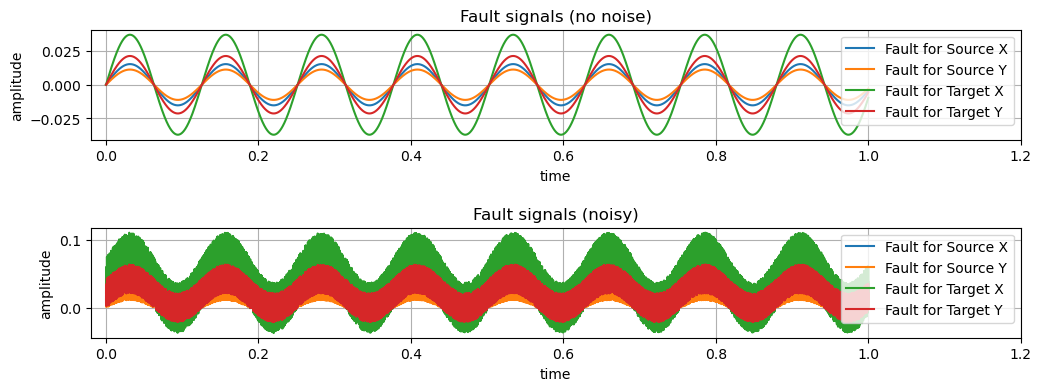

In [51]:
# Showing all faults 
legends = []
leg = ['Source X', 'Source Y', 'Target X', 'Target Y']
for i in range(4):
    legend = 'Fault for ' + leg[i]
    legends.append(legend)

fig, (ax1,ax2)  = plt.subplots(2,1, figsize=(12,4))

# Plot fault with no noise
for i in range(4):

    ax1.plot(f_range,faults[i], label=legends[i])
ax1.set_title('Fault signals (no noise)')
ax1.set_xlabel('time')
ax1.set_ylabel('amplitude')
ax1.legend()
ax1.set_xlim((-0.02,1.2))
ax1.grid()

# Plot noisy fault
for i in range(4):

    ax2.plot(f_range,noised[i], label=legends[i])
ax2.set_title('Fault signals (noisy)')
ax2.set_xlabel('time')
ax2.set_ylabel('amplitude')
ax2.legend()
ax2.set_xlim((-0.02,1.2))
ax2.grid()

plt.subplots_adjust(hspace = 0.8)

Showing a partion of fault signal

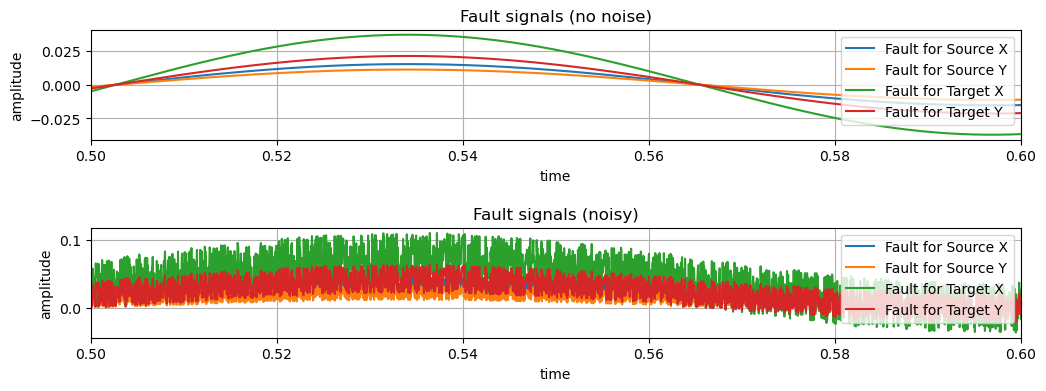

In [52]:
fig, (ax1,ax2)  = plt.subplots(2,1, figsize=(12,4))

# Plot fault with no noise
for i in range(4):

    ax1.plot(f_range,faults[i], label=legends[i])
ax1.set_title('Fault signals (no noise)')
ax1.set_xlabel('time')
ax1.set_ylabel('amplitude')
ax1.legend()
ax1.set_xlim((0.5,0.6))
ax1.grid()

# Plot noisy fault
for i in range(4):

    ax2.plot(f_range,noised[i], label=legends[i])
ax2.set_title('Fault signals (noisy)')
ax2.set_xlabel('time')
ax2.set_ylabel('amplitude')
ax2.legend()
ax2.set_xlim((0.5,0.6))
ax2.grid()

plt.subplots_adjust(hspace = 0.8)

Add noise to Input signals

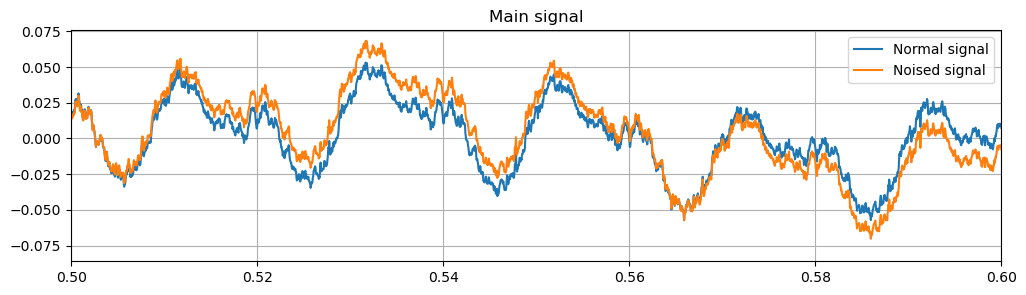

In [77]:
fig= plt.figure(figsize=(12,3))

plt.plot(f_range,x_s[1])
plt.xlim((0.5,0.6))
plt.title('Main signal')
plt.plot(f_range,x_s[1]+faults[0])
plt.legend(['Normal signal', 'Noised signal'])

plt.grid()

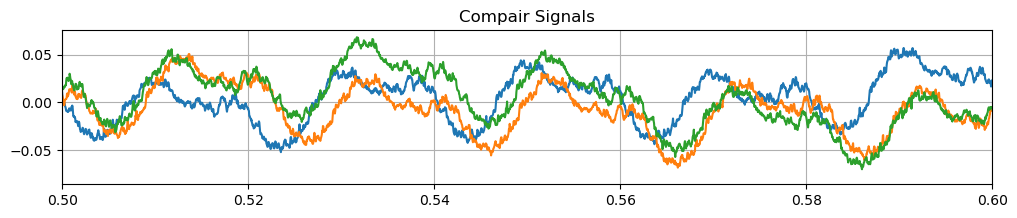

In [79]:
plt.figure(figsize=(12,2))
plt.plot(f_range,x_s[2])
plt.plot(f_range,x_s[0])
plt.plot(f_range,x_s[1]+faults[0])

plt.xlim((0.5,0.6))
plt.grid()
plt.title('Compair Signals');

## Create Noisy data 
---

Here, we add noised to those signals that we want to make them noisy
and create a good dataset.

In [80]:
print(f'There are {len(xl_s)} signals for Source data')
print(f'There are {len(xl_t)} signals for Target data')

There are 8 signals for Source data
There are 4 signals for Target data


So, 4 signals in Source domain and 2 signals in Target domain should 
be fault 

For this purpose, The 1st half stays as normal and the 2nd half, becomes
 fault

In [93]:
# Normal & Fault for Source
x_sf = x_s[int(len(x_s)/2):] + noised[0] # Adding fault
x_sn = x_s[:int(len(x_s)/2)]
x_sl = np.zeros(shape=(len(x_s),)).astype('int8')
x_sl[int(len(x_s)/2):] = 1

# Normal & Fault for Target
x_tf = x_t[int(len(x_t)/2):] + noised[2] # Adding fault
x_tn = x_t[:int(len(x_t)/2)]
x_tl = np.zeros(shape=(len(x_t),)).astype('int8')
x_tl[int(len(x_t)/2):] = 1



Creating a DataFrame for data

In [121]:
# Source data
# Creating string array
data_s = []
for d in x_sn:
    data_s.append(str(list(d)))
for d in x_sf:
    data_s.append(str(list(d)))
source = {'date':xl_s,'data':data_s, 'target':x_sl}
df_s = pd.DataFrame(source)

# Target data
# Creating string array
data_t = []
for d in x_tn:
    data_t.append(str(list(d)))
for d in x_tf:
    data_t.append(str(list(d)))
target= {'date':xl_t,'data':data_t, 'target':x_tl}
df_t = pd.DataFrame(target)